In [22]:
import os
import pandas as pd
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns # визуализация данных
import numpy as np
%matplotlib inline

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, label_binarize

from xgboost import XGBClassifier

In [23]:
xgb_class0_f1 = []
xgb_class1_f1 = []
rndf_class0_f1 = []
rndf_class1_f1 = []

In [33]:
time_ls = [5000, 10000]
for threshold in time_ls:
    %run clean_folder.py -f ./new_mouse_union
    %run clean_folder.py -f ./new_mouse_data_sep
    %run clean_folder.py -f ./new_extracted_data

    %run data_separate_activity_segment.py {threshold}
    %run data_union_same_angle.py
    %run data_extraction.py

    lst = os.listdir('./new_extracted_data')
    lst_data = []
    for file in lst:
        lst_data.append(pd.read_csv('./new_extracted_data/' + file))

    all_data = pd.concat(lst_data, ignore_index=True)
    all_data['section_rel'] = all_data['section_count_after'] / all_data['section_count_before']
    tired_state = len(all_data[all_data.condition == 0]) 
    awake_state = len(all_data[all_data.condition == 1]) 
    n_samples = tired_state if tired_state < awake_state else awake_state
    sampled_0 = resample(all_data[all_data.iloc[:, -2] == 0], replace = False, n_samples = n_samples, random_state=39)
    sampled_1 = resample(all_data[all_data.iloc[:, -2] == 1], replace = False, n_samples = n_samples, random_state=39)
    all_data = pd.concat([sampled_0, sampled_1])

    all_data.drop_duplicates(keep='first', inplace = True)
    Q1 = all_data.quantile(0.25)
    Q3 = all_data.quantile(0.75)
    IQR = Q3 - Q1
    all_data = all_data[~((all_data < (Q1 - 1.5 * IQR)) |(all_data > (Q3 + 1.5 * IQR))).any(axis=1)]
    scale_data = all_data.drop("condition", axis=1)
    scaled_features = StandardScaler().fit_transform(scale_data.values)
    scale_data = pd.DataFrame(scaled_features, index=scale_data.index, columns=scale_data.columns)
    all_data = pd.concat([scale_data,all_data["condition"]], axis=1)

    X = all_data.drop(['condition'], axis = 1)
    y = all_data.condition
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

    grid_param = {'learning_rate': [0.001, 0.01, 0.1], 
        'min_child_weight': [1, 5],
        'max_depth': [1, 2, 5, 10, 20],
        'n_estimators': [10, 50, 100, 500, 1000]
        }
    xgb = XGBClassifier()
    grid_xgb = GridSearchCV(xgb, grid_param, cv = 3)
    grid_xgb.fit(X_train, y_train)
    best_clf = grid_xgb.best_estimator_
    y_pred = best_clf.predict(X_test)
    f1_arr = f1_score(y_test, y_pred, average=None)

    xgb_class0_f1.append(f1_arr[0])
    xgb_class1_f1.append(f1_arr[1])

    grid_param = {
        'n_estimators': [50, 100, 150, 200, 400],
        'criterion': ['gini', 'entropy', 'log_loss'],
        'max_depth': range(2, 16, 2)
    }   
    rfc = RandomForestClassifier()
    grid_rfc = GridSearchCV(rfc, grid_param, cv = 3, n_jobs=-1)
    grid_rfc.fit(X_train, y_train)
    best_clf = grid_rfc.best_estimator_
    y_pred = best_clf.predict(X_test)
    f1_arr = f1_score(y_test, y_pred, average=None)

    rndf_class0_f1.append(f1_arr[0])
    rndf_class1_f1.append(f1_arr[1])

Директория ./new_mouse_union успешно очищена
Директория ./new_mouse_data_sep успешно очищена
Директория ./new_extracted_data успешно очищена
5000
Файл new_mouse_data_sep/00.32.02_2023-11-23.csv успешно сохранен
Файл new_mouse_data_sep/01.26.36_2023-11-13.csv успешно сохранен
Файл new_mouse_data_sep/09.52.12_2023-11-23.csv успешно сохранен
Файл new_mouse_data_sep/14.11.45_2023-11-18.csv успешно сохранен
Файл new_mouse_data_sep/14.13.18_2023-11-18.csv успешно сохранен
Файл new_mouse_data_sep/15.28.15_2023-11-18.csv успешно сохранен
Файл new_mouse_data_sep/23.51.17_2023-11-18.csv успешно сохранен
Файл new_mouse_union/00.32.02_2023-11-23.csv успешно сохранен
Файл new_mouse_union/01.26.36_2023-11-13.csv успешно сохранен
Файл new_mouse_union/09.52.12_2023-11-23.csv успешно сохранен
Файл new_mouse_union/14.11.45_2023-11-18.csv успешно сохранен
Файл new_mouse_union/14.13.18_2023-11-18.csv успешно сохранен
Файл new_mouse_union/15.28.15_2023-11-18.csv успешно сохранен
Файл new_mouse_union/23.51.

<Figure size 640x480 with 0 Axes>

In [36]:
time_ls_for_graph = [100, 200, 300, 500, 1000, 3000, 5000, 10000]

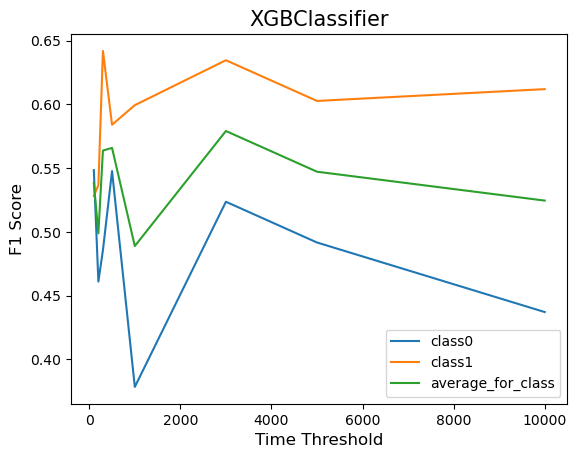

In [41]:
plt.plot(time_ls_for_graph, xgb_class0_f1, label='class0')
plt.plot(time_ls_for_graph, xgb_class1_f1, label='class1')
plt.plot(time_ls_for_graph, [(x+y)/2 for x, y in zip(xgb_class0_f1, xgb_class1_f1)], label='average_for_class')
plt.title('XGBClassifier', fontsize=15)
plt.xlabel('Time Threshold', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.legend()

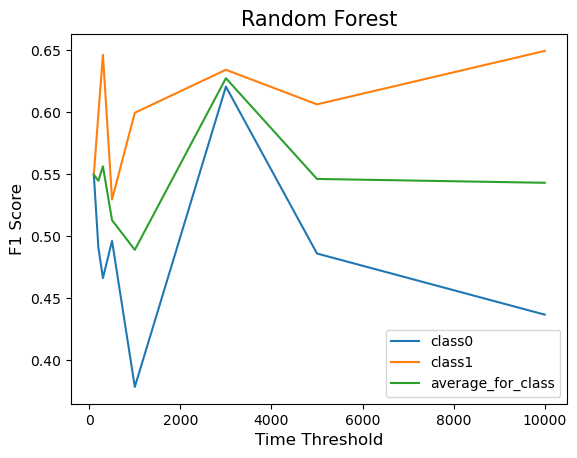

In [43]:
plt.plot(time_ls_for_graph, rndf_class0_f1, label='class0')
plt.plot(time_ls_for_graph, rndf_class1_f1, label='class1')
plt.plot(time_ls_for_graph, [(x+y)/2 for x, y in zip(rndf_class0_f1, rndf_class1_f1)], label='average_for_class')
plt.title('Random Forest', fontsize=15)
plt.xlabel('Time Threshold', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.legend()